In [89]:
import re
import math
import time
import nltk
import torch
import string
import pickle
import random
import requests
import numpy as np
import scipy.sparse
import pandas as pd
import seaborn as sns
from pathlib import Path
from bs4 import BeautifulSoup
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict
from gensim import matutils, models
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel, TextDataset, AdamW

In [2]:
sns.set()

# Scrape transcript data from scrapsfromtheloft.com

In [3]:
def url_to_transcript(url):
    page = requests.get(url).text
    soup = BeautifulSoup(page, "lxml")

    # In order to avoid a failed GET request, I have a fail-safe in place
    try:
        paragraphs = soup.find(class_="elementor-element elementor-element-74af9a5b elementor-widget elementor-widget-theme-post-content").find_all('p')
    except AttributeError:
        time.sleep(3)
        return url_to_transcript(url=url)
        
    text = []
    for p in paragraphs:
        text.append(p.text)

    # Some preprocessing 
    text = ' '.join(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub(r'[^0-9A-Za-z\s]', '', text)
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    
    print(f'Scraped text from {url}')
    return text

In [4]:
# URLs of transcripts in scope
full_names = ['', '', '', '', '', '',
              '', '', '', '.', '', '']
urls = {
    'Louis C.K.': 'http://scrapsfromtheloft.com/2017/05/06/louis-ck-oh-my-god-full-transcript/',
    'Dave Chappelle': 'http://scrapsfromtheloft.com/2017/04/11/dave-chappelle-age-spin-2017-full-transcript/',
    'Ricky Gervais': 'http://scrapsfromtheloft.com/2018/03/15/ricky-gervais-humanity-transcript/',
    'Bo Burnham': 'https://scrapsfromtheloft.com/comedy/bo-burnham-what-transcript/',
    'Bill Burr': 'http://scrapsfromtheloft.com/2017/05/24/bill-burr-im-sorry-feel-way-2014-full-transcript/',
    'Jim Jefferies': 'http://scrapsfromtheloft.com/2017/04/21/jim-jefferies-bare-2014-full-transcript/',
    'John Mulaney': 'http://scrapsfromtheloft.com/2017/08/02/john-mulaney-comeback-kid-2015-full-transcript/',
    'Hasan Minhaj': 'https://scrapsfromtheloft.com/comedy/hasan-minhaj-homecoming-king-transcript/',
    'Ali Wong': 'http://scrapsfromtheloft.com/2017/09/19/ali-wong-baby-cobra-2016-full-transcript/',
    'Anthony Jeselnik': 'http://scrapsfromtheloft.com/2017/08/03/anthony-jeselnik-thoughts-prayers-2015-full-transcript/',
    'Mike Birbiglia': 'http://scrapsfromtheloft.com/2018/03/03/mike-birbiglia-my-girlfriends-boyfriend-2013-full-transcript/',
    'Joe Rogan': 'https://scrapsfromtheloft.com/2018/10/03/joe-rogan-strange-times-transcript/'
}

In [5]:
# Request transcripts
transcripts = [url_to_transcript(url=urls[url]) for url in urls.keys()]
transcripts

Scraped text from http://scrapsfromtheloft.com/2017/05/06/louis-ck-oh-my-god-full-transcript/
Scraped text from http://scrapsfromtheloft.com/2017/04/11/dave-chappelle-age-spin-2017-full-transcript/
Scraped text from http://scrapsfromtheloft.com/2018/03/15/ricky-gervais-humanity-transcript/
Scraped text from https://scrapsfromtheloft.com/comedy/bo-burnham-what-transcript/
Scraped text from http://scrapsfromtheloft.com/2017/05/24/bill-burr-im-sorry-feel-way-2014-full-transcript/
Scraped text from http://scrapsfromtheloft.com/2017/04/21/jim-jefferies-bare-2014-full-transcript/
Scraped text from http://scrapsfromtheloft.com/2017/08/02/john-mulaney-comeback-kid-2015-full-transcript/
Scraped text from https://scrapsfromtheloft.com/comedy/hasan-minhaj-homecoming-king-transcript/
Scraped text from http://scrapsfromtheloft.com/2017/09/19/ali-wong-baby-cobra-2016-full-transcript/
Scraped text from http://scrapsfromtheloft.com/2017/08/03/anthony-jeselnik-thoughts-prayers-2015-full-transcript/
Scr

['introfade the music out lets roll hold there lights do the lights thank you thank you very much i appreciate that i dont necessarily agree with you but i appreciate very much well this is a nice place this is easily the nicest place for many miles in every direction thats how you compliment a building and shit on a town with one sentence it is odd around here as i was driving here there doesnt seem to be any difference between the sidewalk and the street for pedestrians here people just kind of walk in the middle of the road i love traveling and seeing all the different parts of the country i live in new york i live in a theres no value to your doing that at all the old lady and the dogi live i live in new york i always like theres this old lady in my neighborhood and shes always walking her dog shes always just shes very old she just stands there just being old and the dog just fights gravity every day just the two of them its really the dogs got a cloudy eye and shes got a cloudy e

In [6]:
df = pd.DataFrame(data=transcripts, index=urls.keys(), columns=['Transcripts'])
df

,Transcripts
Louis C.K.,introfade the music out lets roll hold there l...
Dave Chappelle,this is dave he tells dirty jokes for a living...
Ricky Gervais,hello hello how you doing great thank you wow ...
Bo Burnham,bo what old macdonald had a farm e i e i o and...
Bill Burr,all right thank you thank you very much thank ...
Jim Jefferies,ladies and gentlemen please welcome to the sta...
John Mulaney,armed with boyish charm and a sharp wit the fo...
Hasan Minhaj,whats up davis whats up im home i had to bring...
Ali Wong,ladies and gentlemen please welcome to the sta...
Anthony Jeselnik,thank you thank you thank you san francisco th...


# Build the document term matrix

In [7]:
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(df['Transcripts'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
data_dtm.index = df.index
data_dtm

,aaaaah,aaaaahhhhhhh,aaaaauuugghhhhhh,aaaahhhhh,aaah,aah,abc,abcs,abdomen,ability,...,zealand,zee,zen,zeppelin,zero,zillion,zombie,zombies,zoning,zoo
Louis C.K.,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
Dave Chappelle,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ricky Gervais,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
Bo Burnham,0,1,1,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
Bill Burr,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,1,1,1,1,0
Jim Jefferies,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
John Mulaney,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hasan Minhaj,0,0,0,0,0,0,0,0,0,0,...,0,2,1,0,1,0,0,0,0,0
Ali Wong,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Anthony Jeselnik,0,0,0,0,0,0,0,0,0,0,...,10,0,0,0,0,0,0,0,0,0


In [8]:
# Display the most common word used by each comedian
data_dtm.apply(lambda x: x.idxmax(), axis=1)

Louis C.K.           like
Dave Chappelle       like
Ricky Gervais       right
Bo Burnham           know
Bill Burr            like
Jim Jefferies        like
John Mulaney         like
Hasan Minhaj         like
Ali Wong             like
Anthony Jeselnik       im
Mike Birbiglia       like
Joe Rogan            like
dtype: object

# Remove any unneccessary terms that may cause overfitting

In [9]:
def most_common_words(df, top_n):
    # Check for non-zero frequencies across all comedians
    common_terms = df.columns[(df > 0).all(axis=0)]

    # Sum the frequencies of these common terms
    common_term_frequencies = df[common_terms].sum().sort_values(ascending=False)

    # Get the top n common words
    top_common_words = common_term_frequencies.head(top_n)

    # Convert to dictionary
    top_common_words_dict = top_common_words.to_dict()

    return top_common_words_dict

In [10]:
top_words = most_common_words(data_dtm, top_n=5)
top_words

{'like': 1621, 'im': 902, 'know': 823, 'just': 813, 'dont': 717}

In [11]:
# Let's update our document-term matrix with the new list of stop words
stop_words = text.ENGLISH_STOP_WORDS.union(top_words.keys())
stop_words = list(stop_words)

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(df['Transcripts'])
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
data_stop.index = df.index
data_stop

,aaaaah,aaaaahhhhhhh,aaaaauuugghhhhhh,aaaahhhhh,aaah,aah,abc,abcs,abdomen,ability,...,zealand,zee,zen,zeppelin,zero,zillion,zombie,zombies,zoning,zoo
Louis C.K.,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
Dave Chappelle,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ricky Gervais,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
Bo Burnham,0,1,1,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
Bill Burr,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,1,1,1,1,0
Jim Jefferies,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
John Mulaney,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hasan Minhaj,0,0,0,0,0,0,0,0,0,0,...,0,2,1,0,1,0,0,0,0,0
Ali Wong,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Anthony Jeselnik,0,0,0,0,0,0,0,0,0,0,...,10,0,0,0,0,0,0,0,0,0


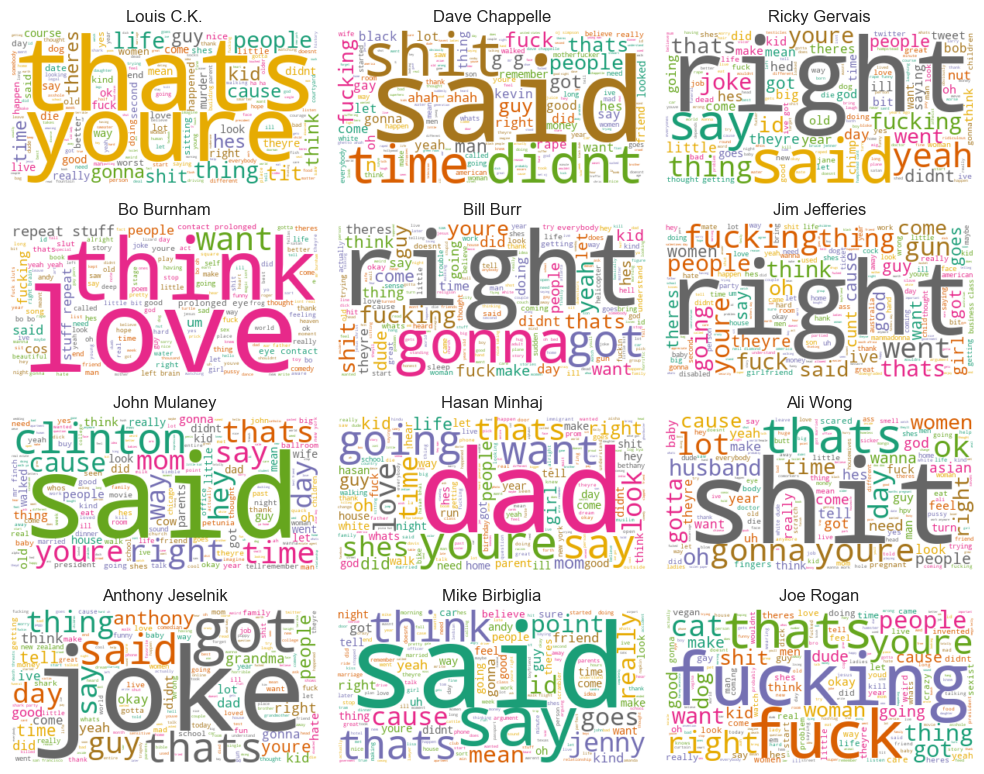

In [12]:
# Initialize WordCloud
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

# Determine the number of rows and columns for the subplots
num_comedians = len(df)
num_cols = 3
num_rows = (num_comedians + num_cols - 1) // num_cols  # Ceiling division

# Create subplots for each comedian with adjusted figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 2 * num_rows))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, (comedian, transcript) in enumerate(df['Transcripts'].items()):
    wc.generate(transcript)
    ax = axes[i]
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(comedian)
    ax.axis("off")

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

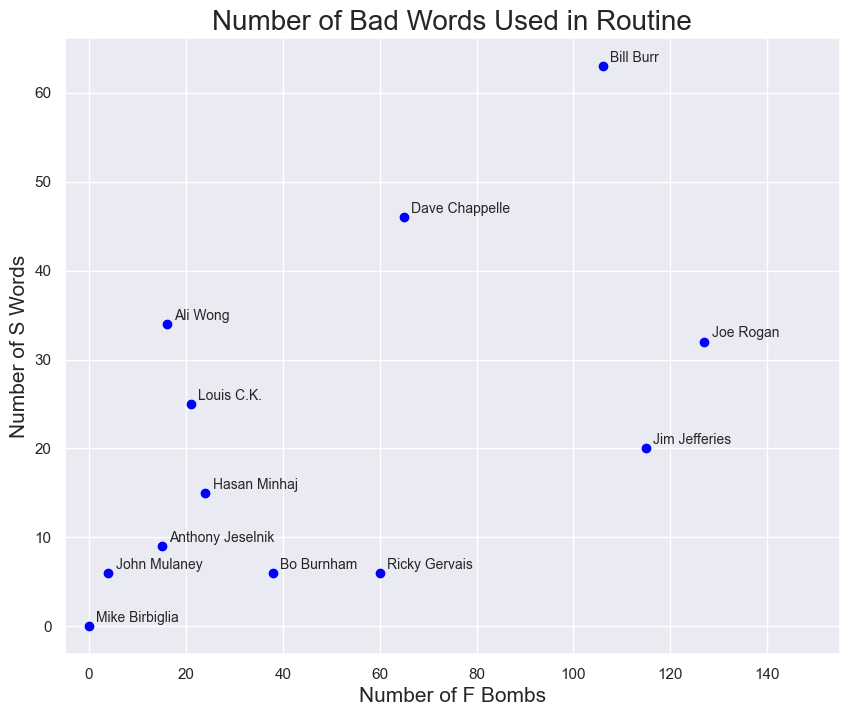

In [13]:
# Let's isolate just these bad words
data_bad_words = data_stop[['fucking', 'fuck', 'shit']]
data_profanity = pd.concat([data_bad_words.fucking + data_bad_words.fuck, data_bad_words.shit], axis=1)
data_profanity.columns = ['f_word', 's_word']
data_profanity

# Let's create a scatter plot of our findings
plt.rcParams['figure.figsize'] = [10, 8]

for i, comedian in enumerate(data_profanity.index):
    x = data_profanity.f_word.loc[comedian]
    y = data_profanity.s_word.loc[comedian]
    plt.scatter(x, y, color='blue')
    plt.text(x+1.5, y+0.5, df.index[i], fontsize=10)
    plt.xlim(-5, 155) 
    
plt.title('Number of Bad Words Used in Routine', fontsize=20)
plt.xlabel('Number of F Bombs', fontsize=15)
plt.ylabel('Number of S Words', fontsize=15)

plt.show()

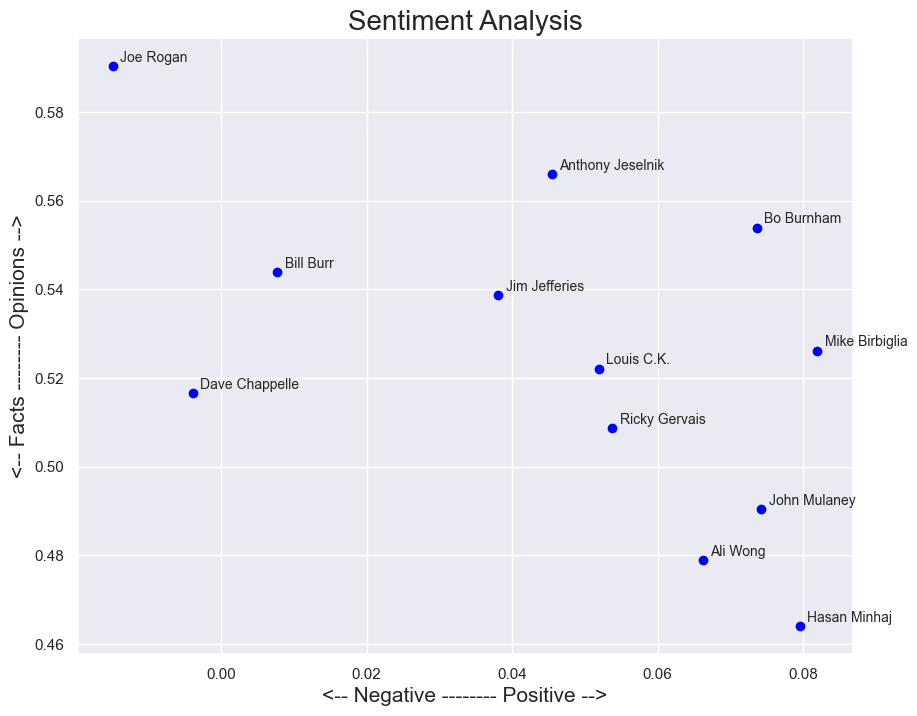

In [14]:
polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

df['polarity'] = df['Transcripts'].apply(polarity)
df['subjectivity'] = df['Transcripts'].apply(subjectivity)

plt.rcParams['figure.figsize'] = [10, 8]

for index, comedian in enumerate(df.index):
    x = df.polarity.loc[comedian]
    y = df.subjectivity.loc[comedian]
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, df.index[index], fontsize=10) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

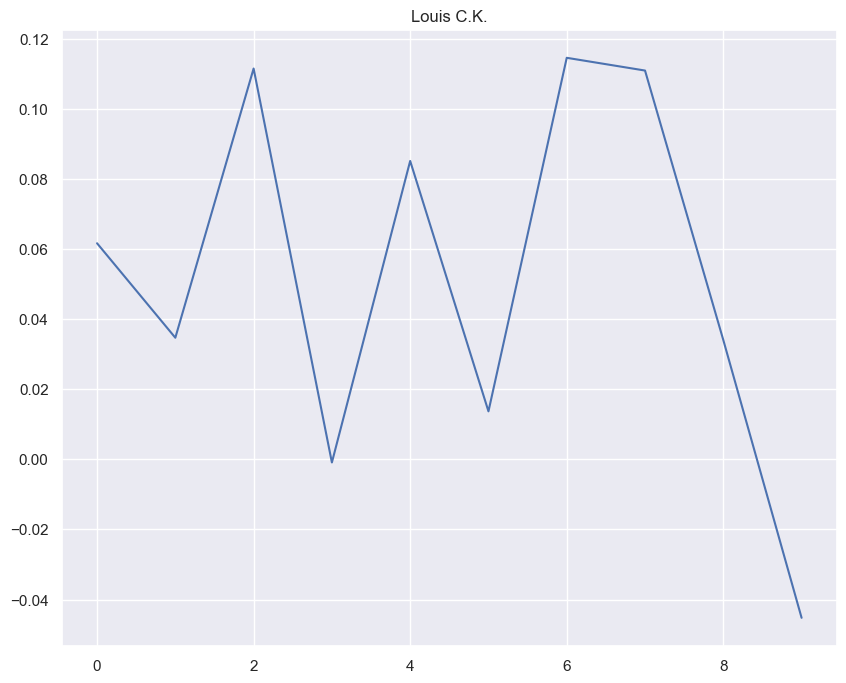

In [15]:
def split_text(text, n):
    # Calculate length of text, the size of each chunk of text and the starting points of each chunk of text
    length = len(text)
    size = math.floor(length / n)
    start = np.arange(0, length, size)
    
    # Pull out equally sized pieces of text and put it into a list
    split_list = []
    for piece in range(n):
        split_list.append(text[start[piece]:start[piece]+size])
        
    return split_list

# Let's create a list to hold all of the pieces of text
list_pieces = []
for t in df['Transcripts']:
    split = split_text(t, n=10)
    list_pieces.append(split)
    
list_pieces

polarity_transcript = []
for lp in list_pieces:
    polarity_piece = []
    for p in lp:
        polarity_piece.append(TextBlob(p).sentiment.polarity)
    polarity_transcript.append(polarity_piece)
    
polarity_transcript
# Show the plot for one comedian
plt.plot(polarity_transcript[0])
plt.title(df.index[0])
plt.show()

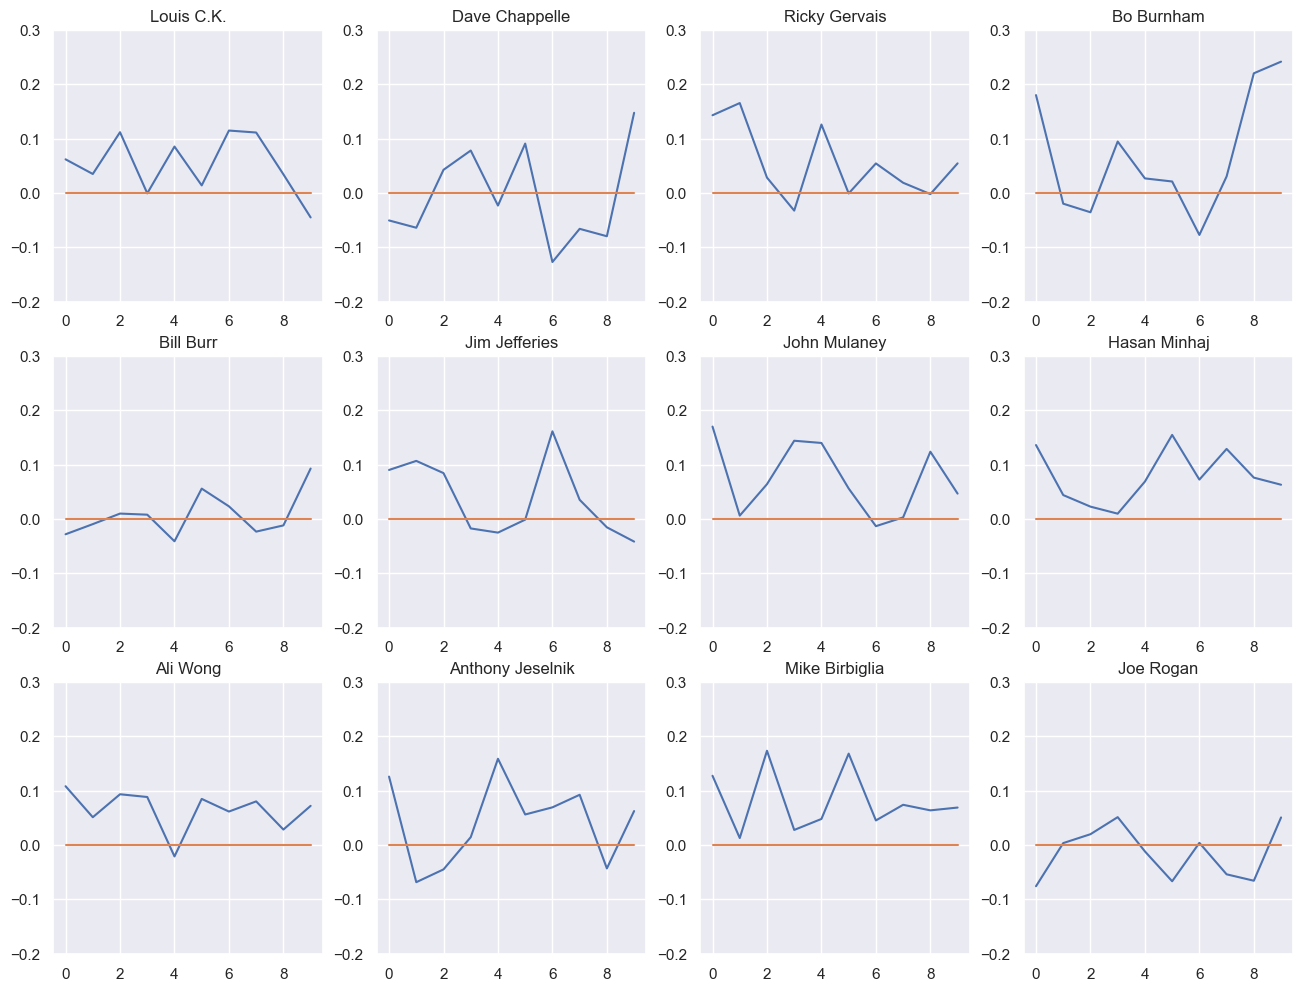

In [16]:
# Show the plot for all comedians
plt.rcParams['figure.figsize'] = [16, 12]

for index, comedian in enumerate(df.index):    
    plt.subplot(3, 4, index+1)
    plt.plot(polarity_transcript[index])
    plt.plot(np.arange(0,10), np.zeros(10))
    plt.title(df.index[index])
    plt.ylim(ymin=-.2, ymax=.3)
    
plt.show()

In [17]:
# We're going to put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(data_dtm)
corpus = matutils.Sparse2Corpus(sparse_counts)

# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [18]:
# Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda.print_topics()

# LDA for num_topics = 3
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda.print_topics()

# LDA for num_topics = 4
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda.print_topics()

[(0,
  '0.318*"abc" + 0.317*"aaaaahhhhhhh" + 0.185*"aaaaah" + 0.002*"aaaahhhhh" + 0.001*"able" + 0.000*"abcs" + 0.000*"abject" + 0.000*"aaah" + 0.000*"aah" + 0.000*"aaaaauuugghhhhhh"'),
 (1,
  '0.235*"aaah" + 0.203*"abject" + 0.179*"able" + 0.138*"abdomen" + 0.063*"aaaaah" + 0.038*"aaaahhhhh" + 0.030*"aaaaahhhhhhh" + 0.013*"abc" + 0.011*"aah" + 0.008*"ability"'),
 (2,
  '0.496*"aaaahhhhh" + 0.000*"aaaaahhhhhhh" + 0.000*"abdomen" + 0.000*"aaaaah" + 0.000*"able" + 0.000*"abject" + 0.000*"ability" + 0.000*"aaaaauuugghhhhhh" + 0.000*"abcs" + 0.000*"aaah"'),
 (3,
  '0.246*"aaaaauuugghhhhhh" + 0.223*"aah" + 0.218*"abcs" + 0.136*"ability" + 0.031*"aaaahhhhh" + 0.024*"abc" + 0.012*"aaaaahhhhhhh" + 0.008*"able" + 0.006*"aaaaah" + 0.005*"aaah"')]

In [19]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Amram\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [20]:
def nouns(text):
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

# Apply the nouns function to the transcripts to filter only on nouns
data_nouns = pd.DataFrame(df['Transcripts'].apply(nouns))
data_nouns

,Transcripts
Louis C.K.,music lets lights lights thank i i place place...
Dave Chappelle,jokes living stare work profound train thought...
Ricky Gervais,hello thank fuck thank im gon youre weve money...
Bo Burnham,macdonald farm e i o farm pig e i i snort macd...
Bill Burr,thank thank pleasure georgia area oasis i june...
Jim Jefferies,ladies gentlemen stage mr jim jefferies thank ...
John Mulaney,charm wit snl writer john mulaney marriage bee...
Hasan Minhaj,whats davis whats home i netflix la york i son...
Ali Wong,ladies gentlemen stage ali hi thank hello na s...
Anthony Jeselnik,thank thank people i em i francisco city world...


In [21]:
# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns['Transcripts'])
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names_out())
data_dtmn.index = data_nouns.index
data_dtmn

,aaaaahhhhhhh,aaaaauuugghhhhhh,aaaahhhhh,aah,abc,abcs,abdomen,ability,abortion,abortions,...,yulin,yummy,ze,zealand,zee,zeppelin,zillion,zombie,zombies,zoo
Louis C.K.,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dave Chappelle,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Ricky Gervais,0,0,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,1
Bo Burnham,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Bill Burr,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,1,1,0
Jim Jefferies,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
John Mulaney,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hasan Minhaj,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Ali Wong,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Anthony Jeselnik,0,0,0,0,0,0,0,0,2,0,...,0,0,0,10,0,0,0,0,0,0


In [22]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

# Let's start with 2 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=2, id2word=id2wordn, passes=10)
ldan.print_topics()

# Let's try topics = 3
ldan = models.LdaModel(corpus=corpusn, num_topics=3, id2word=id2wordn, passes=10)
ldan.print_topics()

# Let's try 4 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.014*"people" + 0.013*"youre" + 0.013*"day" + 0.011*"thing" + 0.009*"thats" + 0.008*"women" + 0.008*"guns" + 0.007*"cause" + 0.007*"fuck" + 0.007*"guy"'),
 (1,
  '0.016*"youre" + 0.015*"people" + 0.013*"thats" + 0.010*"time" + 0.009*"thing" + 0.009*"life" + 0.008*"hes" + 0.007*"way" + 0.007*"day" + 0.007*"cause"'),
 (2,
  '0.011*"day" + 0.011*"thats" + 0.011*"youre" + 0.010*"people" + 0.010*"lot" + 0.010*"time" + 0.009*"joke" + 0.009*"shit" + 0.007*"women" + 0.006*"thing"'),
 (3,
  '0.015*"people" + 0.013*"time" + 0.011*"man" + 0.010*"shit" + 0.008*"ahah" + 0.007*"thats" + 0.007*"fuck" + 0.007*"stuff" + 0.007*"bo" + 0.006*"repeat"')]

In [23]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

# Apply the nouns function to the transcripts to filter only on nouns
data_nouns_adj = pd.DataFrame(df['Transcripts'].apply(nouns_adj))

# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj['Transcripts'])
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names_out())
data_dtmna.index = data_nouns_adj.index
data_dtmna

# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

# Let's start with 2 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=2, id2word=id2wordna, passes=10)
ldana.print_topics()

# Let's try 3 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=3, id2word=id2wordna, passes=10)
ldana.print_topics()

# Let's try 4 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.012*"ahah" + 0.006*"gay" + 0.004*"oj" + 0.004*"ghetto" + 0.004*"young" + 0.004*"motherfucker" + 0.004*"kevin" + 0.003*"mad" + 0.003*"friend" + 0.003*"wife"'),
 (1,
  '0.005*"uh" + 0.004*"ass" + 0.004*"gun" + 0.004*"jenny" + 0.004*"guns" + 0.003*"class" + 0.003*"morning" + 0.003*"business" + 0.003*"girlfriend" + 0.003*"na"'),
 (2,
  '0.005*"dog" + 0.005*"joke" + 0.005*"bo" + 0.004*"cat" + 0.004*"eye" + 0.004*"repeat" + 0.004*"food" + 0.004*"tit" + 0.003*"contact" + 0.003*"nuts"'),
 (3,
  '0.010*"mom" + 0.007*"parents" + 0.006*"joke" + 0.005*"hasan" + 0.005*"clinton" + 0.004*"anthony" + 0.004*"cow" + 0.003*"york" + 0.003*"mad" + 0.003*"friend"')]

In [24]:
# Our final LDA model (for now)
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=80)
ldana.print_topics()

[(0,
  '0.012*"joke" + 0.004*"jokes" + 0.004*"anthony" + 0.004*"hell" + 0.004*"gun" + 0.004*"nuts" + 0.004*"dead" + 0.003*"twitter" + 0.003*"mad" + 0.003*"grandma"'),
 (1,
  '0.005*"dog" + 0.004*"bo" + 0.004*"um" + 0.004*"mom" + 0.004*"hasan" + 0.004*"cat" + 0.004*"repeat" + 0.004*"guns" + 0.003*"eye" + 0.003*"contact"'),
 (2,
  '0.006*"mom" + 0.006*"ok" + 0.006*"clinton" + 0.004*"na" + 0.004*"tit" + 0.004*"husband" + 0.004*"cow" + 0.004*"parents" + 0.003*"wife" + 0.003*"president"'),
 (3,
  '0.008*"ahah" + 0.007*"jenny" + 0.005*"friend" + 0.004*"gay" + 0.003*"accident" + 0.003*"door" + 0.003*"club" + 0.003*"scrambler" + 0.003*"argument" + 0.003*"uh"')]

In [25]:
# Let's take a look at which topics each transcript contains
corpus_transformed = ldana[corpusna]
list(zip([a for [(a,b)] in corpus_transformed], data_dtmna.index))

[(2, 'Louis C.K.'),
 (3, 'Dave Chappelle'),
 (0, 'Ricky Gervais'),
 (1, 'Bo Burnham'),
 (0, 'Bill Burr'),
 (1, 'Jim Jefferies'),
 (2, 'John Mulaney'),
 (1, 'Hasan Minhaj'),
 (2, 'Ali Wong'),
 (0, 'Anthony Jeselnik'),
 (3, 'Mike Birbiglia'),
 (1, 'Joe Rogan')]

In [26]:
def markov_chain(text):
    '''The input is a string of text and the output will be a dictionary with each word as
       a key and each value as the list of words that come after the key in the text.'''
    
    # Tokenize the text by word, though including punctuation
    words = text.split(' ')
    
    # Initialize a default dictionary to hold all of the words and next words
    m_dict = defaultdict(list)
    
    # Create a zipped list of all of the word pairs and put them in word: list of next words format
    for current_word, next_word in zip(words[0:-1], words[1:]):
        m_dict[current_word].append(next_word)

    # Convert the default dict back into a dictionary
    m_dict = dict(m_dict)
    return m_dict

# Create the dictionary for Joe Rogan's routine, take a look at it
rogan_dict = markov_chain(df.loc['Joe Rogan', 'Transcripts'])
rogan_dict

{'oh': ['what',
  'we',
  'we',
  'girls',
  'youre',
  'shes',
  'hate',
  'the',
  'but',
  'is',
  'hi',
  'so',
  'you',
  'dangerous',
  'my',
  'i',
  'oh',
  'okay',
  'my',
  'my',
  'oh',
  'howd'],
 'what': ['the',
  'i',
  'the',
  'they',
  'you',
  'i',
  'were',
  'harvey',
  'a',
  'a',
  'else',
  'else',
  'she',
  'would',
  'to',
  'the',
  'youre',
  'if',
  'if',
  'do',
  'pot',
  'happened',
  'you',
  'the',
  'its',
  'its',
  'it',
  'the',
  'the',
  'four',
  'you',
  'do',
  'are',
  'are',
  'are',
  'he',
  'have',
  'i',
  'the',
  'word',
  'are',
  'to',
  'the',
  'you',
  'the',
  'i',
  'i',
  'are',
  'theyre',
  'im',
  'that',
  'are',
  'are',
  'i',
  'i',
  'the',
  'is',
  'if',
  'it',
  'the',
  'to',
  'i',
  'its',
  'to',
  'they',
  'they',
  'to',
  'we',
  'weve',
  'childhood',
  'about',
  'that',
  'do',
  'else',
  'i',
  'about',
  'we',
  'men',
  'women',
  'about',
  'did',
  'you',
  'you',
  'whats',
  'if'],
 'the': ['fuck'

In [27]:
def generate_sentence(chain, count=30):
    '''Input a dictionary in the format of key = current word, value = list of next words
       along with the number of words you would like to see in your generated sentence.'''

    # Capitalize the first word
    word1 = random.choice(list(chain.keys()))
    sentence = word1.capitalize()

    # Generate the second word from the value list. Set the new word as the first word. Repeat.
    for i in range(count-1):
        word2 = random.choice(chain[word1])
        word1 = word2
        sentence += ' ' + word2

    # End it with a period
    sentence += '.'
    return(sentence)

In [28]:
generate_sentence(rogan_dict)

'Bunch of that cat a story there was so i think theres money if he dont want bigger dicks than women do you but bill oreilly they pull out of.'

# The markov chain clearly only employs short term dependencies and can't generate coherent text on its own and can be replaced with a transformer possibly

In [106]:
class JokeDataset(Dataset):
    def __init__(self, transcripts, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attention_masks = []
        
        for transcript in transcripts:
            encodings = tokenizer(transcript, truncation=True, max_length=max_length, padding="max_length", return_tensors="pt")
            self.input_ids.append(encodings.input_ids)
            self.attention_masks.append(encodings.attention_mask)
        
        self.input_ids = torch.cat(self.input_ids)
        self.attention_masks = torch.cat(self.attention_masks)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_masks[idx]

def fine_tune_gpt2(df: pd.DataFrame, output_dir: str, epochs: int = 3, batch_size: int = 32, lr: float = 1e-5):
    # Save the transcripts to a text file
    with open("transcripts.txt", "w") as f:
        for transcript in df['Transcripts']:
            f.write(transcript + "\n")
    
    # Load tokenizer and model
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.add_special_tokens({'pad_token': '[PAD]', 'eos_token': '[EOS]', 'bos_token': '[BOS]', 'unk_token': '[UNK]'})
    model = GPT2LMHeadModel.from_pretrained("gpt2")
    model.resize_token_embeddings(len(tokenizer))

    # Create dataset and dataloader
    dataset = JokeDataset(df['Transcripts'].tolist(), tokenizer)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create optimizer
    optimizer = AdamW(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0
        model.train()
        for batch in train_dataloader:
            input_ids, attention_masks = batch
            labels = input_ids[:, 1:].contiguous()
            input_ids = input_ids[:, :-1].contiguous()
            outputs = model(input_ids, attention_mask=attention_masks[:, :-1].contiguous(), labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
            
        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Average training loss: {avg_train_loss}")

        model.eval()
        total_eval_loss = 0
        for batch in val_dataloader:
            input_ids, attention_masks = batch
            labels = input_ids[:, 1:].contiguous()
            input_ids = input_ids[:, :-1].contiguous()
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_masks[:, :-1].contiguous(), labels=labels)
                loss = outputs.loss
                
            total_eval_loss += loss.item()
            
        avg_val_loss = total_eval_loss / len(val_dataloader)
        print(f"Validation loss: {avg_val_loss}")

    # Save the fine-tuned model
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    return model, tokenizer

In [107]:
# Fine-tune the model
output_dir = "./fine_tuned_gpt2"
model, tokenizer = fine_tune_gpt2(df, output_dir)

Epoch 1/3
Average training loss: 110.80946350097656
Validation loss: 112.12828826904297
Epoch 2/3
Average training loss: 103.52603912353516
Validation loss: 109.27747344970703
Epoch 3/3
Average training loss: 99.17281341552734
Validation loss: 106.42044830322266


In [116]:
def generate_joke(model: GPT2LMHeadModel, tokenizer: GPT2Tokenizer, max_length: int = 50) -> str:
    # Generate text
    input_ids = tokenizer.encode("<|endoftext|>", return_tensors='pt')
    print("Tokenized input:", input_ids)

    generated_text_samples = model.generate(
        input_ids=input_ids,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        repetition_penalty=2.0,
        top_p=0.92,
        top_k=50,
        temperature=0.85,
        do_sample=True,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )
    print("Generated token IDs:", generated_text_samples)

    # Decode the generated text
    generated_text = tokenizer.decode(generated_text_samples[0], skip_special_tokens=True)
    # Add special tokens manually
    generated_text = "<|endoftext|>" + generated_text + "<|endoftext|>"

    return generated_text

In [117]:
joke = generate_joke(model, tokenizer)
print(joke)

Tokenized input: tensor([[50256]])
Generated token IDs: tensor([[50256, 50258]])
<|endoftext|><|endoftext|><|endoftext|>


# With enough training, tuning, data, and computing power, transfer learning with gpt2 could very well generate high quality jokes with the humor of a comedian of choice